In [ ]:
# pip install pandas numpy scikit-learn matplotlib tensorflow

In [1]:
import pandas as pd
import numpy as np
import IPython
import IPython.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, Flatten, Attention
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

In [2]:
# 1. Load the dataset
data = pd.read_csv('./data/BrentOilPricesMerged.csv')

In [3]:
# 2. Preprocess the data
# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [4]:
data.head()

,Price,neg_oil,neu_oil,pos_oil,compound_oil,neg_war,neu_war,pos_war,compound_war
Date,,,,,,,,,
2023-04-03,84.930000,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-04,84.940002,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-05,84.989998,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-06,85.120003,0.000,0.000,0.000,0.0000,0.000,0.776,0.224,0.9866
2023-04-10,84.180000,0.086,0.816,0.098,0.9796,0.144,0.708,0.147,-0.1356


In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,271.0,82.667343,5.567707,71.839996,78.139999,82.739998,86.355000,96.550003
neg_oil,271.0,0.023033,0.024112,0.000000,0.000000,0.017500,0.038271,0.116000
neu_oil,271.0,0.496814,0.361231,0.000000,0.000000,0.604750,0.831000,0.960000
pos_oil,271.0,0.064340,0.055087,0.000000,0.000000,0.062000,0.100667,0.181000
compound_oil,271.0,0.378112,0.429797,-0.955900,0.000000,0.270900,0.950900,0.999900
neg_war,271.0,0.082097,0.071262,0.000000,0.013000,0.073000,0.132375,0.272500
neu_war,271.0,0.802173,0.128576,0.000000,0.773586,0.817200,0.854250,1.000000
pos_war,271.0,0.104691,0.065619,0.000000,0.066000,0.118000,0.139875,0.435000
compound_war,271.0,0.163507,0.595739,-0.999900,-0.357750,0.115525,0.701659,0.986600


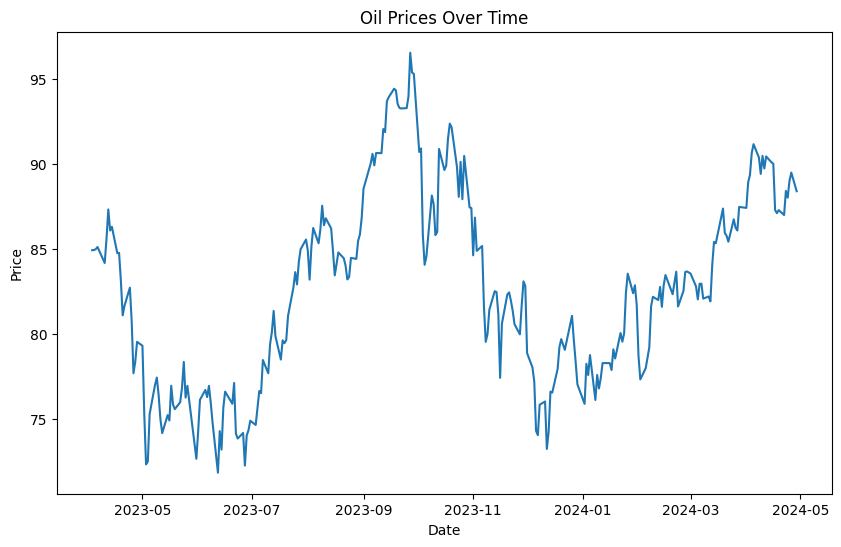

In [6]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Price'])
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [7]:
column_indices = {name: i for i, name in enumerate(data.columns)}
column_indices

{'Price': 0,
 'neg_oil': 1,
 'neu_oil': 2,
 'pos_oil': 3,
 'compound_oil': 4,
 'neg_war': 5,
 'neu_war': 6,
 'pos_war': 7,
 'compound_war': 8}

In [8]:
# Extract the relevant columns for oil sentiment data
# oil_data = data[['Price', 'neg_oil', 'neu_oil', 'pos_oil', 'compound_oil', 'neg_war', 'neu_war', 'pos_war', 'compound_war']]
# oil_data = data[['Price']]
oil_data = data[['Price', 'neg_oil', 'neu_oil', 'pos_oil', 'compound_oil']]
oil_data.head()

,Price,neg_oil,neu_oil,pos_oil,compound_oil
Date,,,,,
2023-04-03,84.930000,0.000,0.000,0.000,0.0000
2023-04-04,84.940002,0.000,0.000,0.000,0.0000
2023-04-05,84.989998,0.000,0.000,0.000,0.0000
2023-04-06,85.120003,0.000,0.000,0.000,0.0000
2023-04-10,84.180000,0.086,0.816,0.098,0.9796


In [9]:
# Normalize the price data
scaler = MinMaxScaler(feature_range=(0, 1))
oil_data['Price'] = scaler.fit_transform(oil_data['Price'].values.reshape(-1, 1))
# oil_data = scaler.fit_transform(oil_data)

C:\Users\wgras\AppData\Local\Temp\ipykernel_18092\1558082071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_data['Price'] = scaler.fit_transform(oil_data['Price'].values.reshape(-1, 1))


In [10]:
n = len(oil_data)
train_df = oil_data[0:int(n*0.7)]
val_df = oil_data[int(n*0.7):int(n*0.875)]
test_df = oil_data[int(n*0.875):]

In [11]:
# train = 70%
# validation = 17.5%
# test - 12.5%

In [11]:
test_df

,Price,neg_oil,neu_oil,pos_oil,compound_oil
Date,,,,,
2024-03-12,0.407932,0.037667,0.400333,0.062000,0.188300
2024-03-13,0.493323,0.000000,0.575333,0.091333,0.493300
2024-03-14,0.549575,0.083200,0.843600,0.073200,0.005620
2024-03-15,0.546337,0.046500,0.710000,0.077333,0.266667
2024-03-18,0.609065,0.044000,0.399667,0.056500,0.277767
2024-03-19,0.628895,0.022714,0.751714,0.082714,0.442286
2024-03-20,0.571024,0.011250,0.686250,0.052500,0.431050
2024-03-21,0.564144,0.049000,0.582000,0.069000,0.177520
2024-03-22,0.549980,0.038000,0.595714,0.080571,0.357286


In [12]:
len(train_df),len(val_df),len(test_df)

(189, 48, 34)

In [13]:
train_df.columns

Index(['Price', 'neg_oil', 'neu_oil', 'pos_oil', 'compound_oil'], dtype='object')

In [14]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [15]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=1,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [17]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def all_data(self):
  return self.make_dataset(oil_data)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.all_data = all_data
WindowGenerator.example = example

In [18]:
val_performance = {}
performance = {}
histories={}
models_list={}
windows_list={}

windows_dictionary = {
    'weekly': 7, 
    'bi-weekly': 14, 
    'monthly': 30,       
}


In [19]:
for w in windows_dictionary:
    input_width=windows_dictionary[w]
    window = WindowGenerator(
        input_width=input_width, label_width=1, shift=1,
        label_columns=['Price']
    )
    windows_list[w]=window

In [20]:
windows_list

{'weekly': Total window size: 8
 Input indices: [0 1 2 3 4 5 6]
 Label indices: [7]
 Label column name(s): ['Price'],
 'bi-weekly': Total window size: 15
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 Label indices: [14]
 Label column name(s): ['Price'],
 'monthly': Total window size: 31
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29]
 Label indices: [30]
 Label column name(s): ['Price']}

In [21]:
windows_list['monthly']

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [22]:
MAX_EPOCHS = 100

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)

def compile_and_fit(model, window, patience=4):
  model.compile(
    # loss='mean_absolute_percentage_error',
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer='adam',
    metrics=[
      tf.keras.metrics.MeanAbsolutePercentageError(),
      # tf.keras.metrics.MeanSquaredError()
      tf.keras.metrics.MeanAbsoluteError(),
    ]
  )

  history = model.fit(
    window.train, 
    epochs=MAX_EPOCHS, 
    validation_data=window.val,
    callbacks=[early_stopping,reduce_lr]
  )

  return history

1. Linear model

In [23]:
train_df.shape

(189, 5)

In [24]:
window=windows_list['monthly']
seq_length=30
input_shape=(seq_length, train_df.shape[1])
window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [25]:
input_shape

(30, 5)

In [26]:
def get_cnn_model_1(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    return model

model=get_cnn_model_1(input_shape)
# model=get_transformer_model(input_shape)

In [27]:
history = compile_and_fit(model, window)

histories_Linear = history
val_performance_Linear = model.evaluate(window.val, return_dict=True)
performance_Linear = model.evaluate(window.test, verbose=1, return_dict=True)

Epoch 1/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0295 - mean_absolute_percentage_error: 1083826.7500 - mean_absolute_error: 0.1385 - val_loss: 0.1085 - val_mean_absolute_percentage_error: 73.7351 - val_mean_absolute_error: 0.3278 - lr: 0.0010
Epoch 2/100
159/159 [==============================] - 0s 3ms/step - loss: 0.0645 - mean_absolute_percentage_error: 631352.6875 - mean_absolute_error: 0.1999 - val_loss: 0.0905 - val_mean_absolute_percentage_error: 67.2816 - val_mean_absolute_error: 0.2994 - lr: 0.0010
Epoch 3/100
159/159 [==============================] - 0s 3ms/step - loss: 0.0287 - mean_absolute_percentage_error: 1052764.0000 - mean_absolute_error: 0.1333 - val_loss: 0.1053 - val_mean_absolute_percentage_error: 72.3377 - val_mean_absolute_error: 0.3221 - lr: 0.0010
Epoch 4/100
159/159 [==============================] - 0s 3ms/step - loss: 0.0439 - mean_absolute_percentage_error: 1180615.5000 - mean_absolute_error: 0.1668 - val_loss: 0.0907 - val_mean

In [28]:
histories_Linear.history.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_percentage_error', 'val_mean_absolute_error', 'lr'])

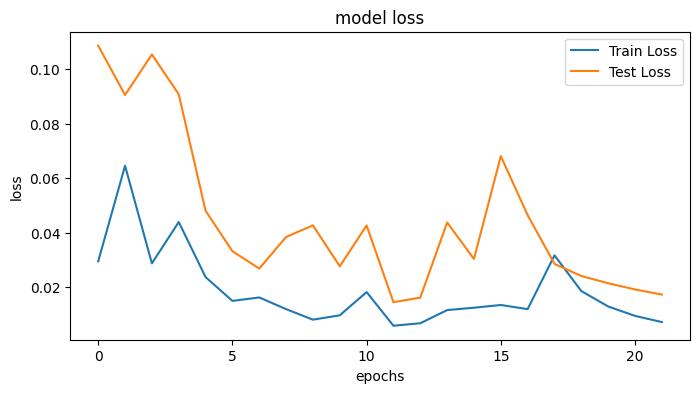

In [29]:
# Plot Train vs Test Loss
plt.figure(figsize=(8,4))
plt.plot(histories_Linear.history['loss'], label='Train Loss')
plt.plot(histories_Linear.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [30]:
all_predict = model.predict(window.all_data)
all_predict

241/241 [==============================] - 0s 1ms/step


array([[0.19526955],
       [0.2639626 ],
       [0.28244358],
       [0.27432415],
       [0.27415156],
       [0.27607036],
       [0.2698832 ],
       [0.25228745],
       [0.24633941],
       [0.12368444],
       [0.09407163],
       [0.14257589],
       [0.19063485],
       [0.19424754],
       [0.20316869],
       [0.27724653],
       [0.21894047],
       [0.16359672],
       [0.13955367],
       [0.16690814],
       [0.18033585],
       [0.20507203],
       [0.1778218 ],
       [0.19835567],
       [0.23338264],
       [0.19733787],
       [0.16997021],
       [0.17049992],
       [0.13020085],
       [0.14985588],
       [0.13691114],
       [0.14007491],
       [0.1627812 ],
       [0.24146268],
       [0.313051  ],
       [0.33964592],
       [0.40246835],
       [0.46864486],
       [0.52957946],
       [0.5886914 ],
       [0.5329169 ],
       [0.5384873 ],
       [0.55901396],
       [0.5872535 ],
       [0.6175042 ],
       [0.6708956 ],
       [0.77829975],
       [0.811

In [31]:
all_predict.shape

(241, 1)

In [32]:
X_all_data = scaler.inverse_transform(all_predict)
# Y_test = np.array([s[1][0][0][0].numpy() for s in iter(window.test)])
Y_all_data = oil_data['Price'].values
Y_all_data = scaler.inverse_transform(Y_all_data.reshape(-1, 1))

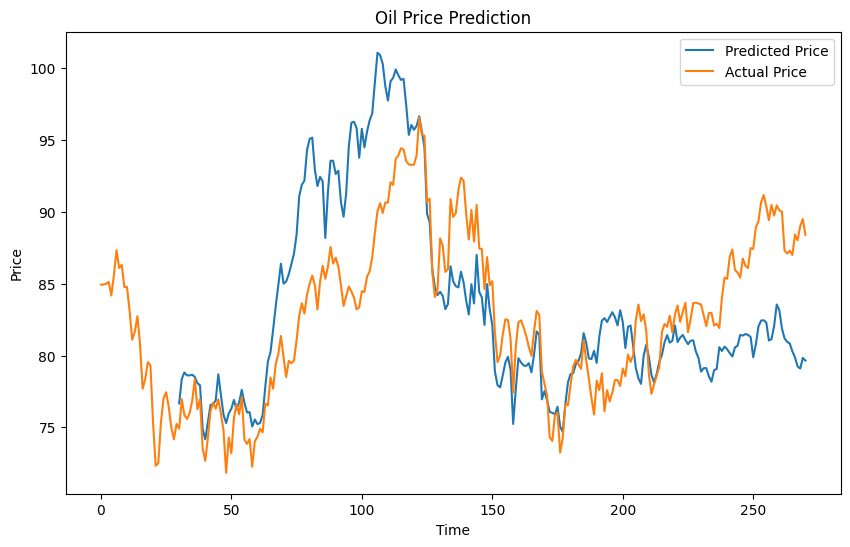

In [33]:
# Plot predictions vs actual values
seq_length = 30

plt.figure(figsize=(10, 6))

plt.plot(range(seq_length, seq_length + len(X_all_data)), X_all_data, label='Predicted Price')
plt.plot(range(len(Y_all_data)), Y_all_data, label='Actual Price')
plt.title('Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [34]:
# Basic 1D CNN Model
def get_cnn_model_1(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    return model

In [35]:
# Deeper 1D CNN Model
def get_cnn_model_2(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    return model

In [36]:
# 1D CNN with Dropout
def get_cnn_model_3(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    return model


In [37]:
# 1D CNN with Global Max Pooling
from tensorflow.keras.layers import GlobalMaxPooling1D

def get_cnn_model_4(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    return model


In [38]:
# 1D CNN with Residual Connections
from tensorflow.keras.layers import Add

def get_cnn_model_5(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    residual = Conv1D(filters=64, kernel_size=1, padding='same')(inputs)
    x = Add()([x, residual])
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [39]:
models_name_list={
    'cnn_model_1' : get_cnn_model_1 ,
    'cnn_model_2' : get_cnn_model_2 ,
    'cnn_model_3' : get_cnn_model_3 ,
    'cnn_model_4' : get_cnn_model_4 ,
    'cnn_model_5' : get_cnn_model_5 ,
}
models_list={}

In [40]:
for model_type in models_name_list:
    print(model_type)

cnn_model_1
cnn_model_2
cnn_model_3
cnn_model_4
cnn_model_5


In [41]:
def create_model_for_each_model_type(model_type):
    for window_name in windows_dictionary:
        seq_length=windows_dictionary[window_name]
        window = windows_list[window_name]
        input_shape=(seq_length, train_df.shape[1])


        model_name=f'{model_type}_{window_name}'
        print('\n\n\n--------------',model_name, input_shape, '--------------')
        model = models_name_list[model_type](input_shape)
        print(model.summary())
        
        models_list[model_name]= {
            'model':model,
            'window':window,
            'seq_length':seq_length

        }


In [42]:
for model_type in models_name_list:
    print('\n------------',model_type,'------------')
    create_model_for_each_model_type(model_type)


------------ cnn_model_1 ------------



-------------- cnn_model_1_weekly (7, 5) --------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 5, 64)             1024      
                                                                 
 flatten_1 (Flatten)         (None, 320)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                16050     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 17125 (66.89 KB)
Trainable params: 17125 (66.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None



-------------- cnn_model_1_bi-weekly (14, 5)

In [43]:
models_list

{'cnn_model_1_weekly': {'model': <keras.src.engine.sequential.Sequential at 0x1af8f100250>,
  'window': Total window size: 8
  Input indices: [0 1 2 3 4 5 6]
  Label indices: [7]
  Label column name(s): ['Price'],
  'seq_length': 7},
 'cnn_model_1_bi-weekly': {'model': <keras.src.engine.sequential.Sequential at 0x1af8f1766d0>,
  'window': Total window size: 15
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
  Label indices: [14]
  Label column name(s): ['Price'],
  'seq_length': 14},
 'cnn_model_1_monthly': {'model': <keras.src.engine.sequential.Sequential at 0x1af8f0e7750>,
  'window': Total window size: 31
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
   24 25 26 27 28 29]
  Label indices: [30]
  Label column name(s): ['Price'],
  'seq_length': 30},
 'cnn_model_2_weekly': {'model': <keras.src.engine.sequential.Sequential at 0x1af8f195950>,
  'window': Total window size: 8
  Input indices: [0 1 2 3 4 5 6]
  Label indices: [7]
  

In [44]:
len(models_list)

15

In [45]:
for model_name in models_list:
    model = models_list[model_name]['model']
    window = models_list[model_name]['window']
    
    print('\n\n\n------------',model_name,'------------')
    history = compile_and_fit(model, window)

    histories[model_name] = history
    print('------------val performance')
    val_performance[model_name] = model.evaluate(window.val, return_dict=True)
    print('------------test performance')
    performance[model_name] = model.evaluate(window.test, verbose=1, return_dict=True)




------------ cnn_model_1_weekly ------------
Epoch 1/100
182/182 [==============================] - 1s 3ms/step - loss: 0.0637 - mean_absolute_percentage_error: 1296829.1250 - mean_absolute_error: 0.1835 - val_loss: 0.0548 - val_mean_absolute_percentage_error: 56.1743 - val_mean_absolute_error: 0.2212 - lr: 0.0010
Epoch 2/100
182/182 [==============================] - 0s 2ms/step - loss: 0.0268 - mean_absolute_percentage_error: 599580.0000 - mean_absolute_error: 0.1313 - val_loss: 0.0410 - val_mean_absolute_percentage_error: 47.0242 - val_mean_absolute_error: 0.1882 - lr: 0.0010
Epoch 3/100
182/182 [==============================] - 0s 2ms/step - loss: 0.0172 - mean_absolute_percentage_error: 728689.6875 - mean_absolute_error: 0.1053 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 37.1030 - val_mean_absolute_error: 0.1501 - lr: 0.0010
Epoch 4/100
182/182 [==============================] - 0s 2ms/step - loss: 0.0141 - mean_absolute_percentage_error: 751555.3125 - mean_absolu

## evaluate

In [46]:
histories

{'cnn_model_1_weekly': <keras.src.callbacks.History at 0x1af8f878d50>,
 'cnn_model_1_bi-weekly': <keras.src.callbacks.History at 0x1af9092aa10>,
 'cnn_model_1_monthly': <keras.src.callbacks.History at 0x1af91152a10>,
 'cnn_model_2_weekly': <keras.src.callbacks.History at 0x1af935caa10>,
 'cnn_model_2_bi-weekly': <keras.src.callbacks.History at 0x1af93fa2a10>,
 'cnn_model_2_monthly': <keras.src.callbacks.History at 0x1af960b2a10>,
 'cnn_model_3_weekly': <keras.src.callbacks.History at 0x1af9644aa10>,
 'cnn_model_3_bi-weekly': <keras.src.callbacks.History at 0x1af96052a10>,
 'cnn_model_3_monthly': <keras.src.callbacks.History at 0x1af98f2aa10>,
 'cnn_model_4_weekly': <keras.src.callbacks.History at 0x1af9a40eb90>,
 'cnn_model_4_bi-weekly': <keras.src.callbacks.History at 0x1af9c1d2a10>,
 'cnn_model_4_monthly': <keras.src.callbacks.History at 0x1af9a392a10>,
 'cnn_model_5_weekly': <keras.src.callbacks.History at 0x1af9c547790>,
 'cnn_model_5_bi-weekly': <keras.src.callbacks.History at 0x1

In [47]:
len(histories)

15

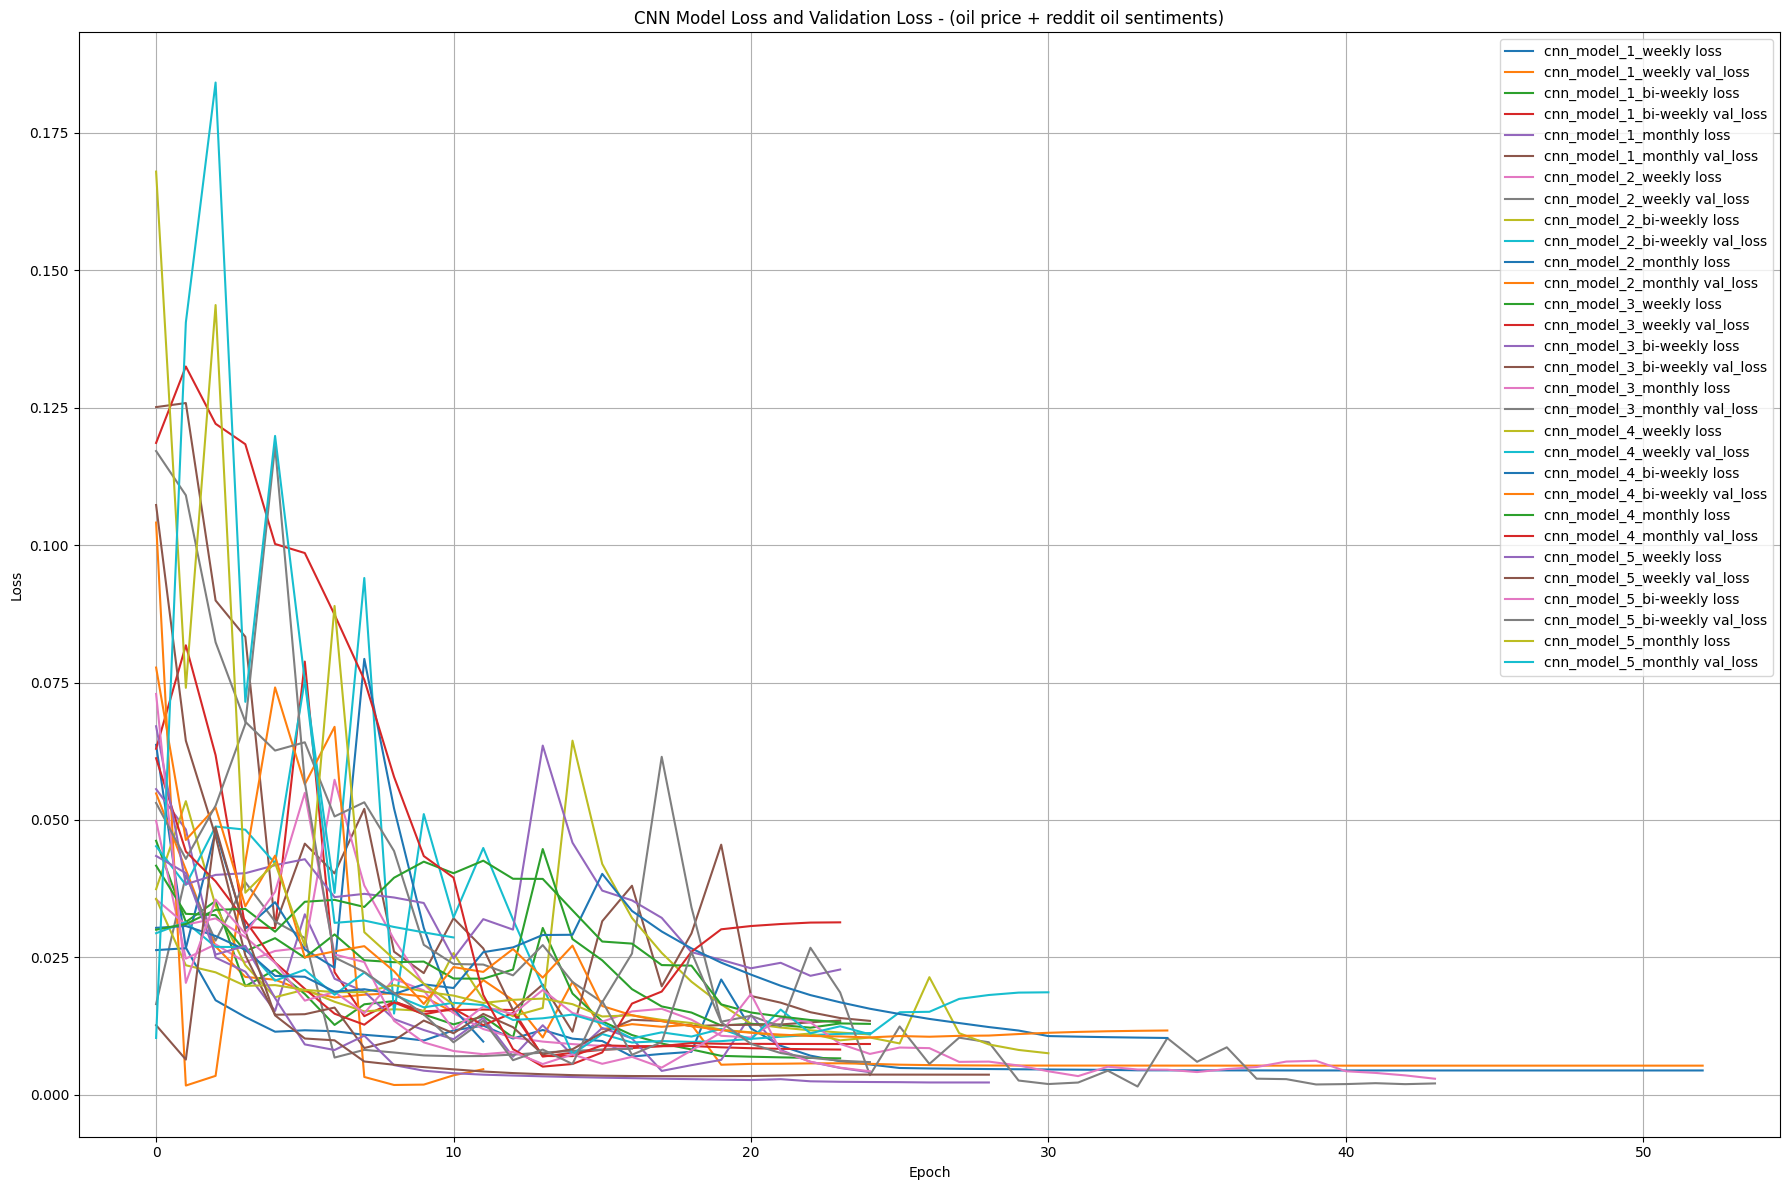

In [51]:
plt.figure(figsize=(18, 12))
for h in (histories):    # Plot Train vs Test Loss
    history=histories[h]
    plt.plot(history.history['loss'], label=f'{h} loss')
    plt.plot(history.history['val_loss'], label=f'{h} val_loss')

plt.title('CNN Model Loss and Validation Loss - (oil price + reddit oil sentiments)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil_reddit_oil/CNN model loss all models (oil price + reddit oil sentiments).png')

In [52]:
val_performance

{'cnn_model_1_weekly': {'loss': 0.005304745398461819,
  'mean_absolute_percentage_error': 15.483490943908691,
  'mean_absolute_error': 0.05539426580071449},
 'cnn_model_1_bi-weekly': {'loss': 0.006955849938094616,
  'mean_absolute_percentage_error': 18.864213943481445,
  'mean_absolute_error': 0.06456369906663895},
 'cnn_model_1_monthly': {'loss': 0.011477548629045486,
  'mean_absolute_percentage_error': 22.143701553344727,
  'mean_absolute_error': 0.099371999502182},
 'cnn_model_2_weekly': {'loss': 0.0067776585929095745,
  'mean_absolute_percentage_error': 21.223602294921875,
  'mean_absolute_error': 0.06571318954229355},
 'cnn_model_2_bi-weekly': {'loss': 0.007395550608634949,
  'mean_absolute_percentage_error': 20.514816284179688,
  'mean_absolute_error': 0.0739772692322731},
 'cnn_model_2_monthly': {'loss': 0.0016847931547090411,
  'mean_absolute_percentage_error': 8.123346328735352,
  'mean_absolute_error': 0.036028072237968445},
 'cnn_model_3_weekly': {'loss': 0.00703315250575542

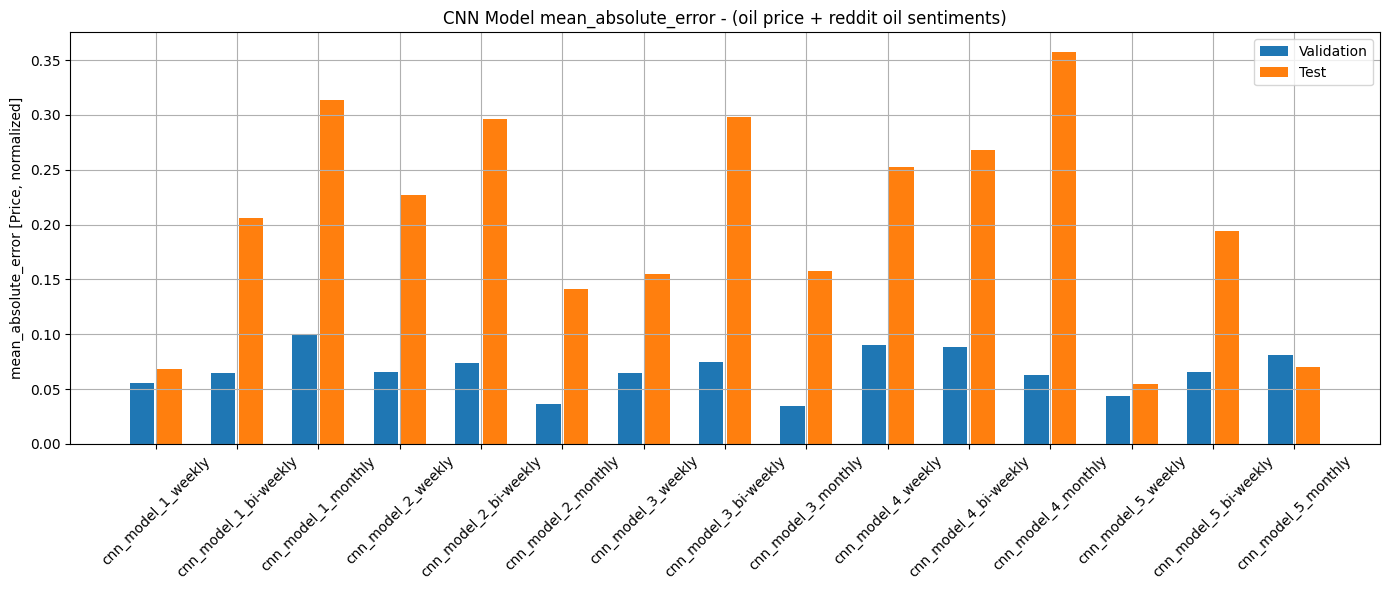

In [53]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.figure(figsize=(14, 6))
plt.title('CNN Model mean_absolute_error - (oil price + reddit oil sentiments)')
plt.ylabel('mean_absolute_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil_reddit_oil/CNN mean_absolute_error all models (oil price + reddit oil sentiments).png')


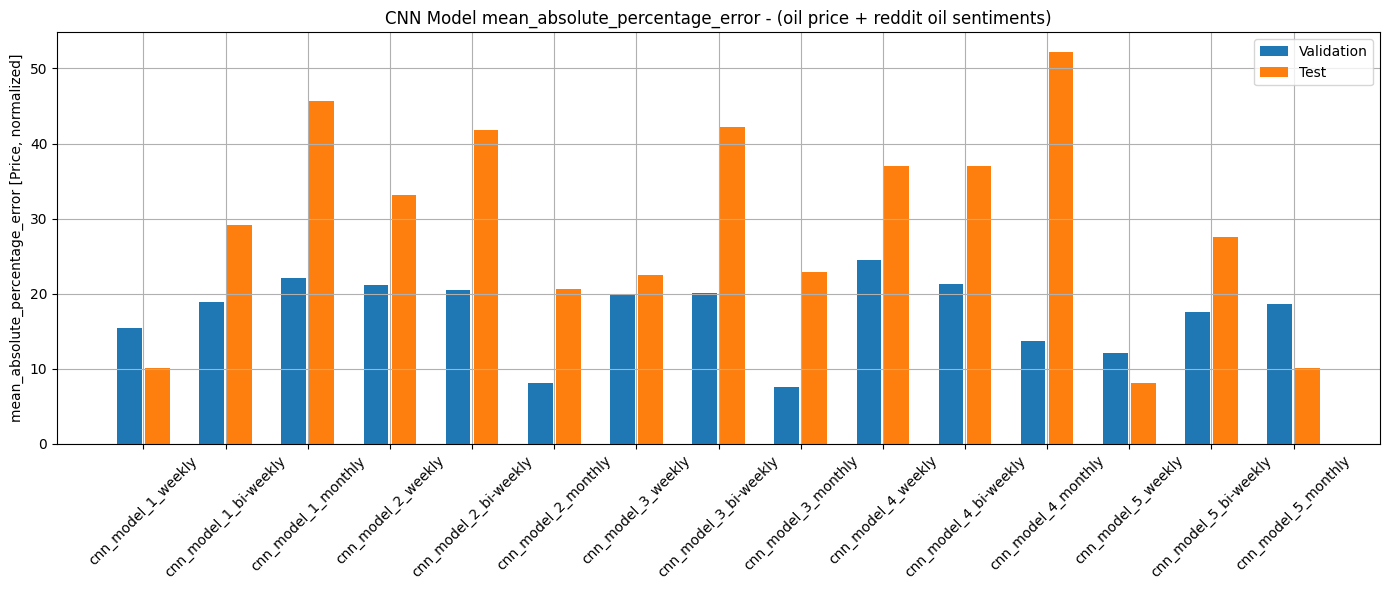

In [54]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_percentage_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]
plt.figure(figsize=(14, 6))
plt.title('CNN Model mean_absolute_percentage_error - (oil price + reddit oil sentiments)')
plt.ylabel('mean_absolute_percentage_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil_reddit_oil/CNN mean_absolute_percentage_error all models (oil price + reddit oil sentiments).png')

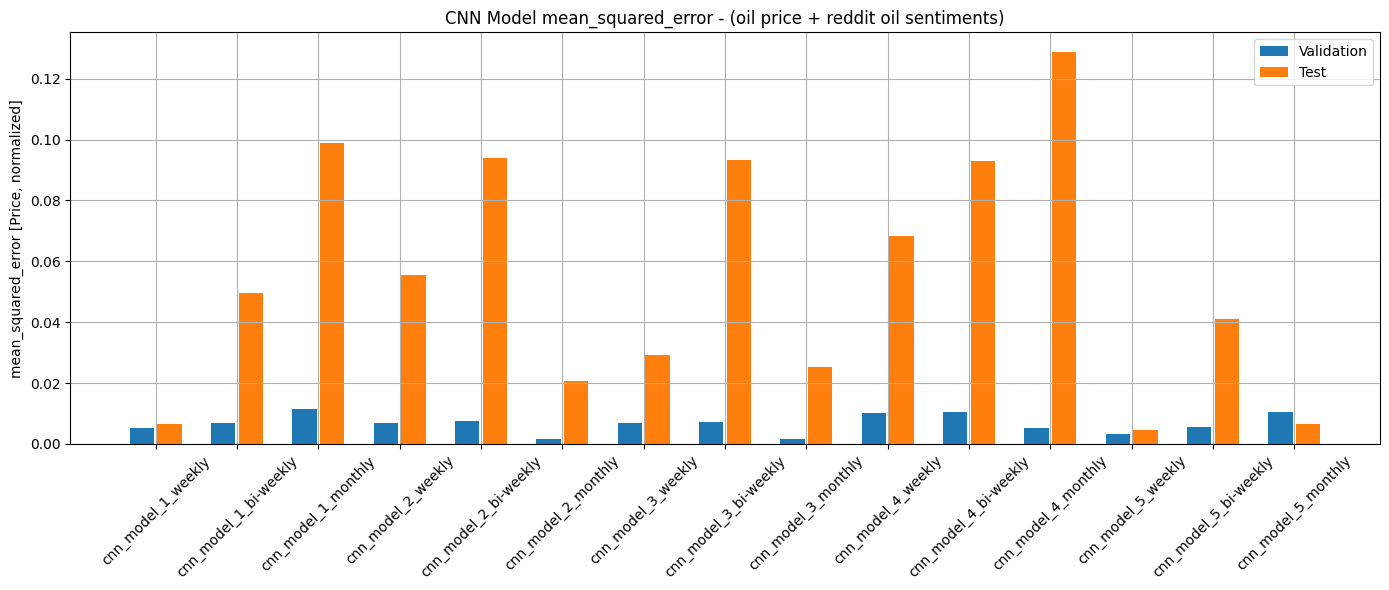

In [55]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_squared_error '
val_mae = [v['loss'] for v in val_performance.values()]
test_mae = [v['loss'] for v in performance.values()]
plt.figure(figsize=(14, 6))
plt.title('CNN Model mean_squared_error - (oil price + reddit oil sentiments)')
plt.ylabel('mean_squared_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil_reddit_oil/CNN mean_squared_error all models (oil price + reddit oil sentiments).png')

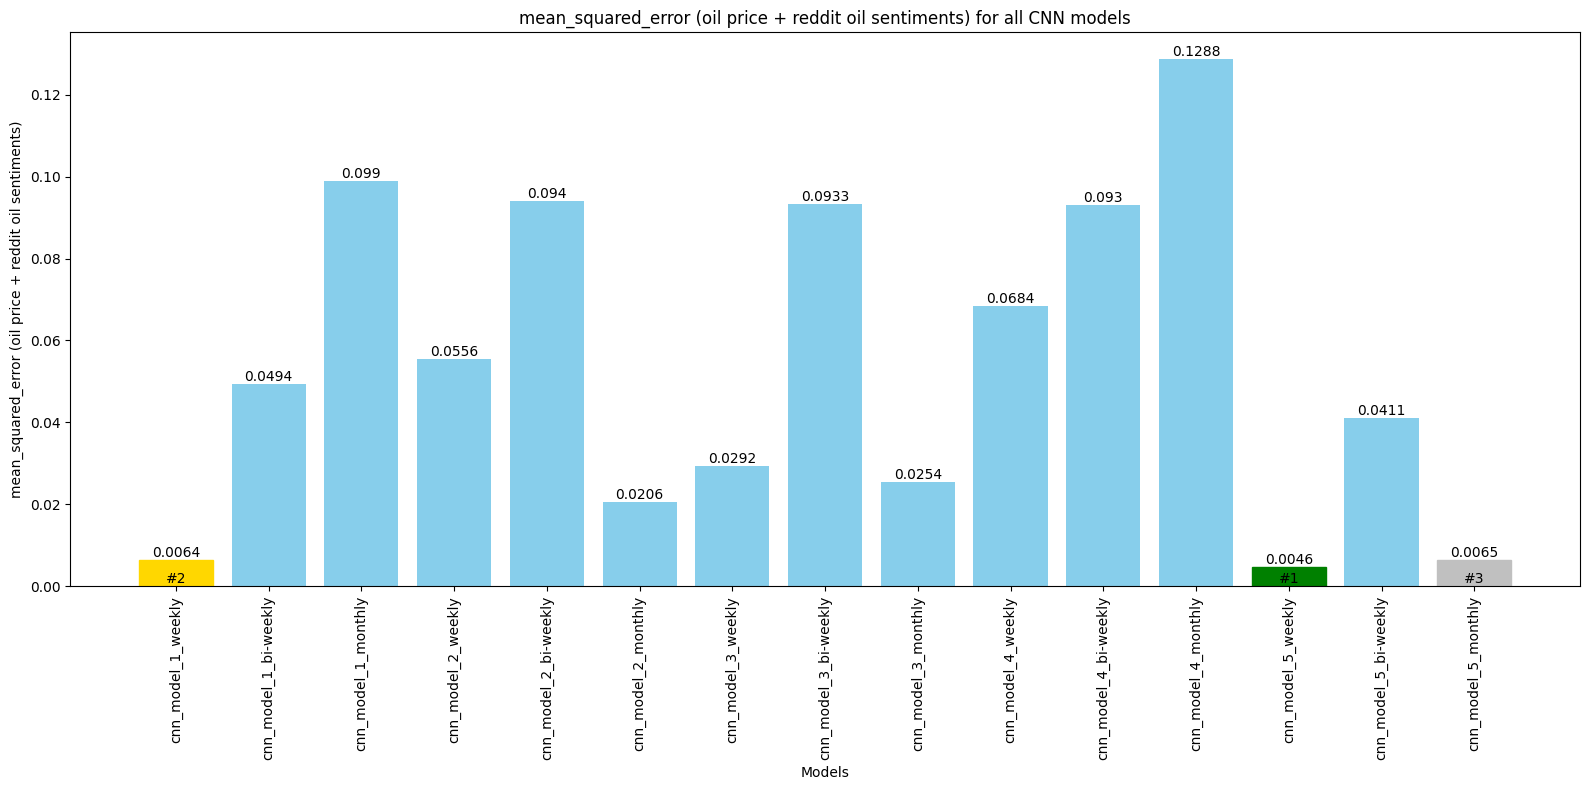

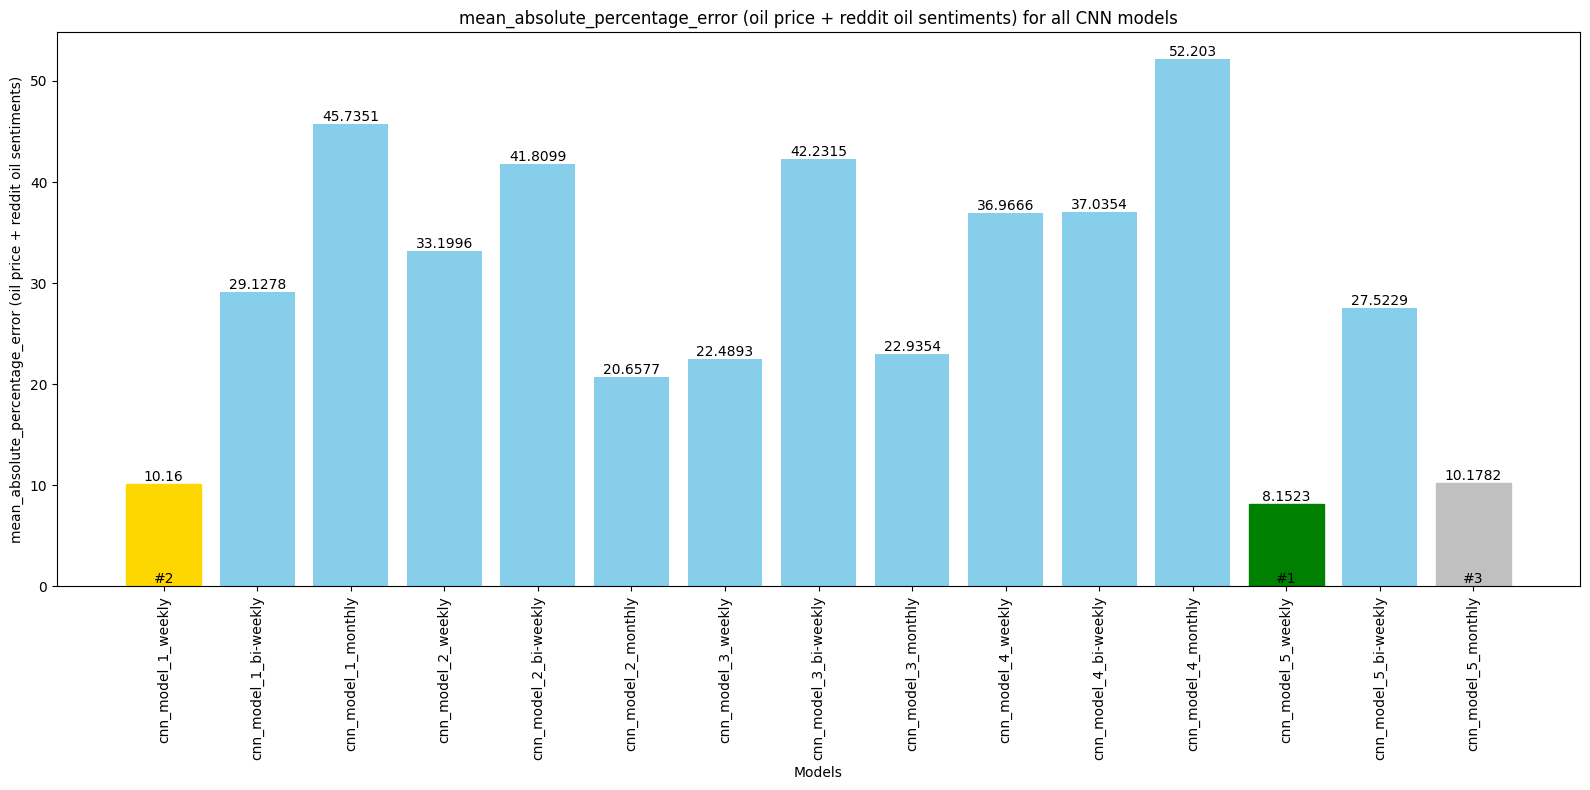

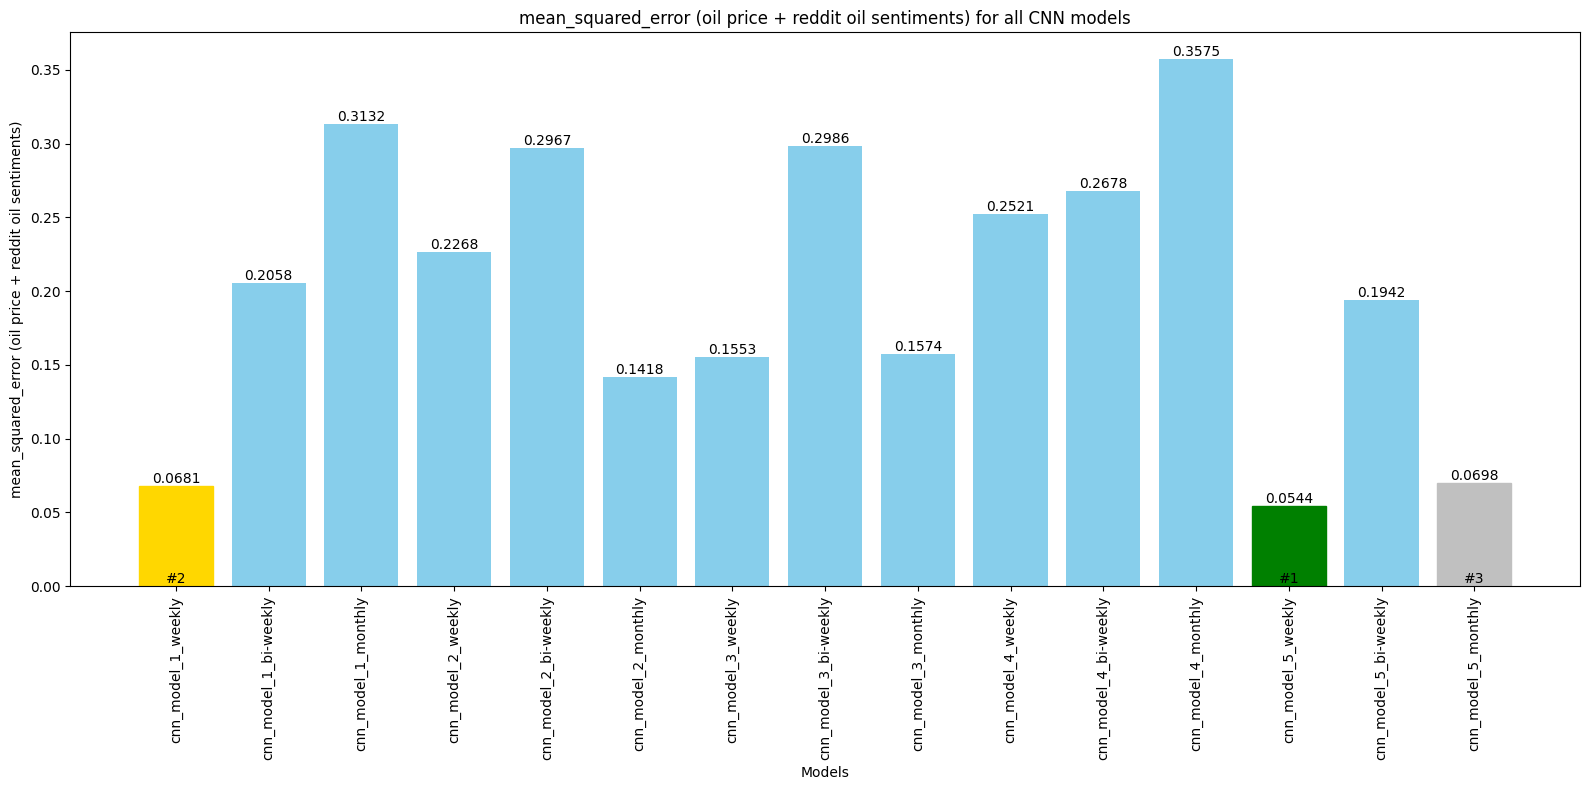

Top 3 models with minimum loss: ['cnn_model_5_weekly', 'cnn_model_1_weekly', 'cnn_model_5_monthly']
Top 3 models with minimum mean_absolute_error: ['cnn_model_5_weekly', 'cnn_model_1_weekly', 'cnn_model_5_monthly']
Top 3 models with minimum mean_squared_error: ['cnn_model_5_weekly', 'cnn_model_1_weekly', 'cnn_model_5_monthly']


In [56]:
# Extract data for each metric
models = list(performance.keys())
loss_values = [performance[model]['loss'] for model in models]
mae_values = [performance[model]['mean_absolute_percentage_error'] for model in models]
mse_values = [performance[model]['mean_absolute_error'] for model in models]

# Function to plot and save a metric, highlighting the best model
def plot_and_save_metric(metric_values, metric_name, best_models_indices):
    plt.figure(figsize=(16, 8))
    bars = plt.bar(models, metric_values, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for all CNN models')
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Highlight the best models with different colors
    colors = ['green', 'gold', 'silver']
    for rank, index in enumerate(best_models_indices):
        bars[index].set_color(colors[rank])
        yval = bars[index].get_height()

        plt.text(bars[index].get_x() + bars[index].get_width()/2,  0, f'#{rank+1}', ha='center', va='bottom')

    # Annotate all bars with their values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

    plt.savefig(f'outputs/oil_reddit_oil/CNN {metric_name}_comparison.png')
    plt.show()

# Find the indices of the top 3 models with the minimum values for each metric
top_n = 3

min_loss_indices = np.argsort(loss_values)[:top_n]
min_mae_indices = np.argsort(mae_values)[:top_n]
min_mse_indices = np.argsort(mse_values)[:top_n]
# Plot and save loss
plot_and_save_metric(loss_values, 'mean_squared_error (oil price + reddit oil sentiments)', min_loss_indices)

# Plot and save mean_absolute_error
plot_and_save_metric(mae_values, 'mean_absolute_percentage_error (oil price + reddit oil sentiments)', min_mae_indices)

# Plot and save mean_squared_error
plot_and_save_metric(mse_values, 'mean_squared_error (oil price + reddit oil sentiments)', min_mse_indices)

# Get the model names for the top 3 models
min_loss_models = [models[i] for i in min_loss_indices]
min_mae_models = [models[i] for i in min_mae_indices]
min_mse_models = [models[i] for i in min_mse_indices]

print(f'Top {top_n} models with minimum loss: {min_loss_models}')
print(f'Top {top_n} models with minimum mean_absolute_error: {min_mae_models}')
print(f'Top {top_n} models with minimum mean_squared_error: {min_mse_models}')

In [57]:
model_name='cnn_model_5_weekly' 
model = models_list[model_name]['model']
window = models_list[model_name]['window']
seq_length = models_list[model_name]['seq_length']

In [58]:
window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['Price']

In [59]:
seq_length

7

In [60]:
all_predict = model.predict(window.all_data)
print(all_predict.shape)

264/264 [==============================] - 1s 1ms/step
(264, 1)


In [61]:
all_predict[0]

array([0.5445412], dtype=float32)

264/264 [==============================] - 0s 1ms/step


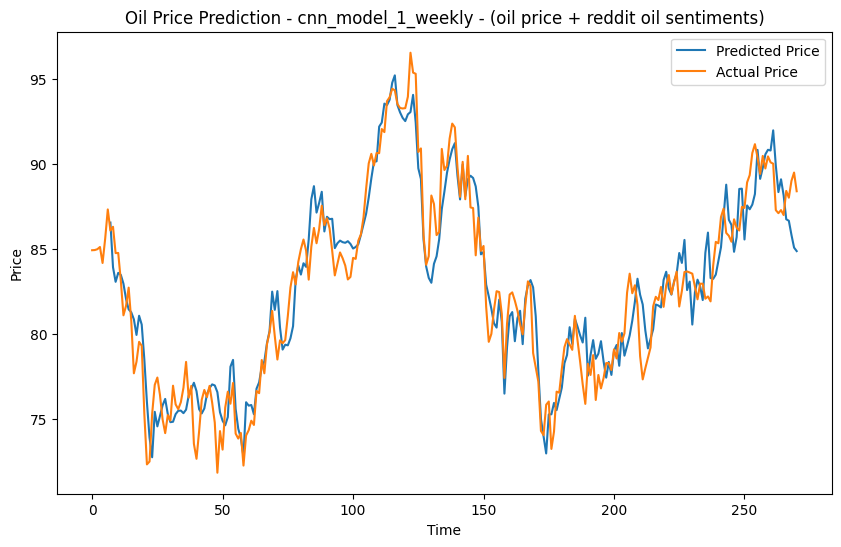

257/257 [==============================] - 1s 2ms/step


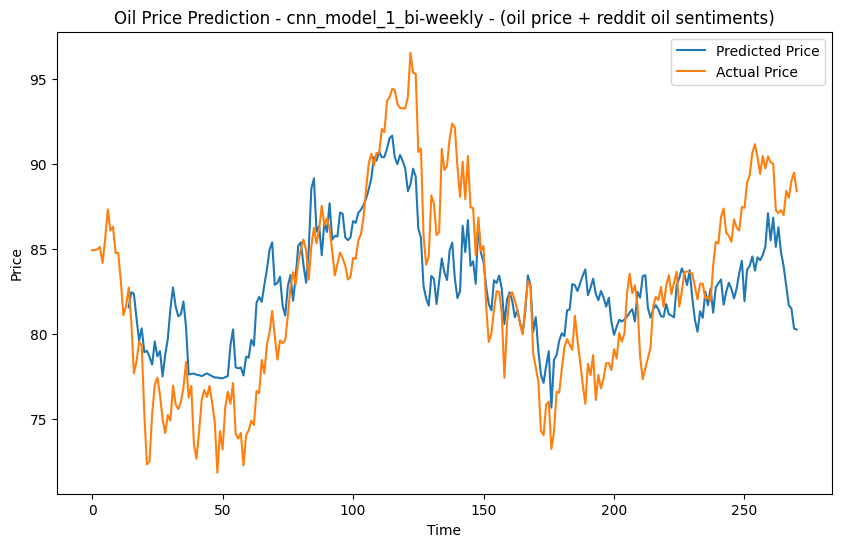

241/241 [==============================] - 0s 1ms/step


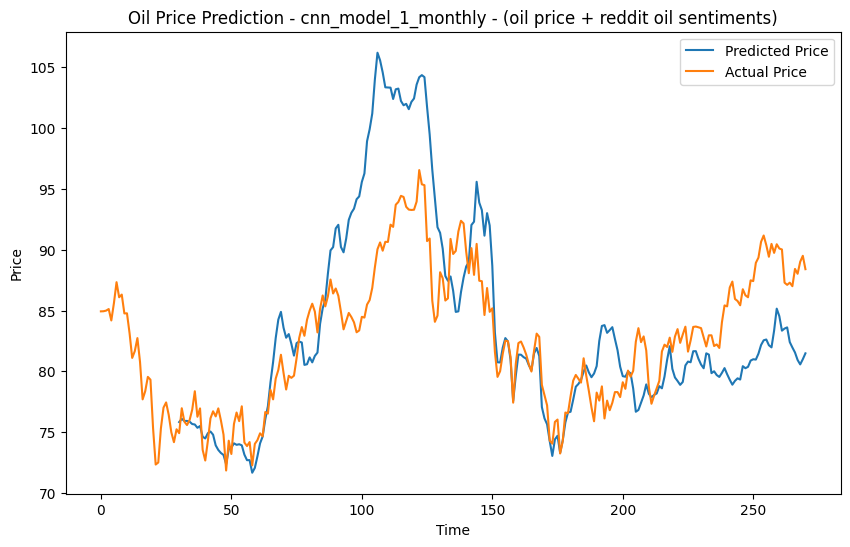

264/264 [==============================] - 0s 1ms/step


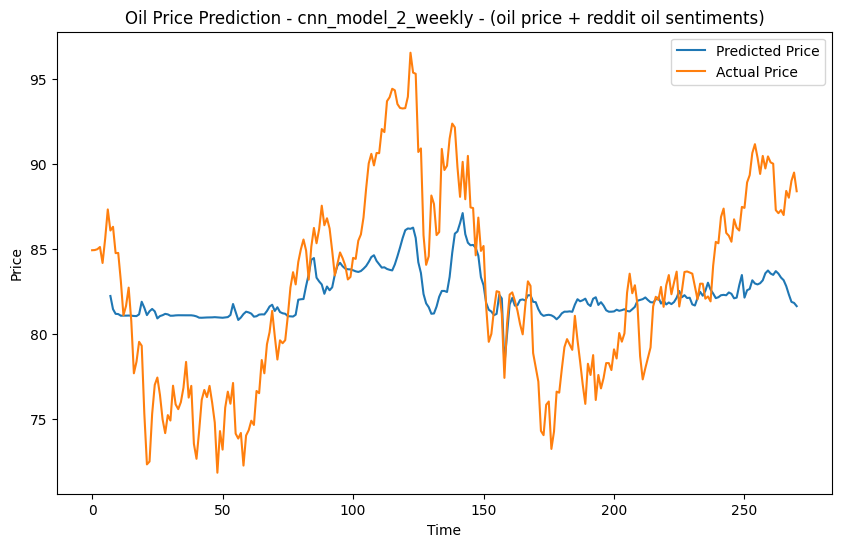

257/257 [==============================] - 0s 1ms/step


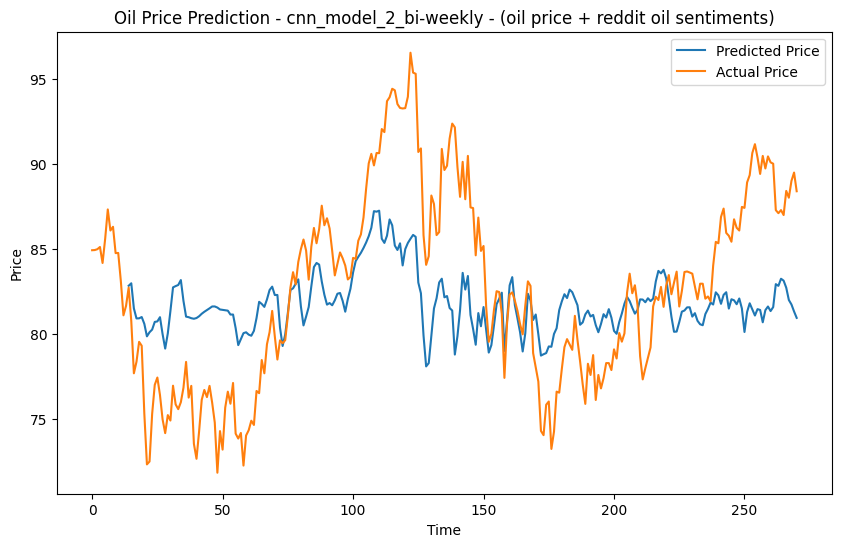

241/241 [==============================] - 0s 2ms/step


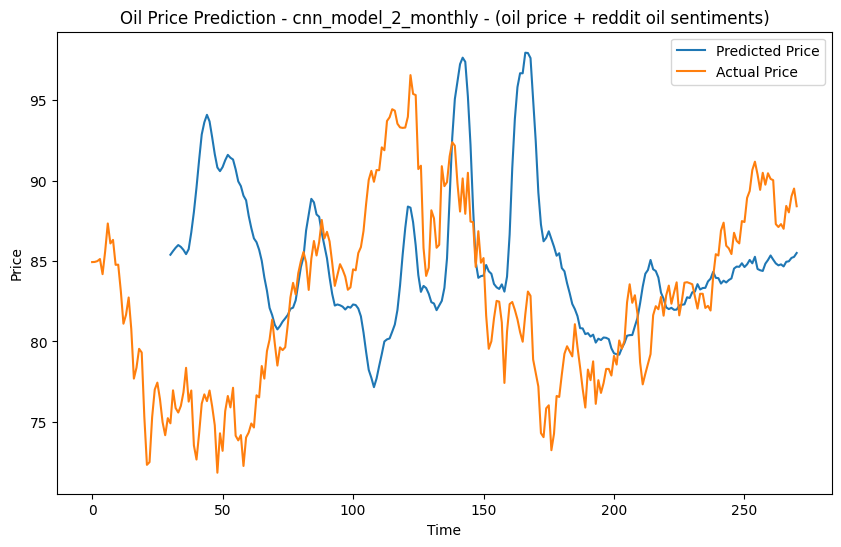

264/264 [==============================] - 1s 1ms/step


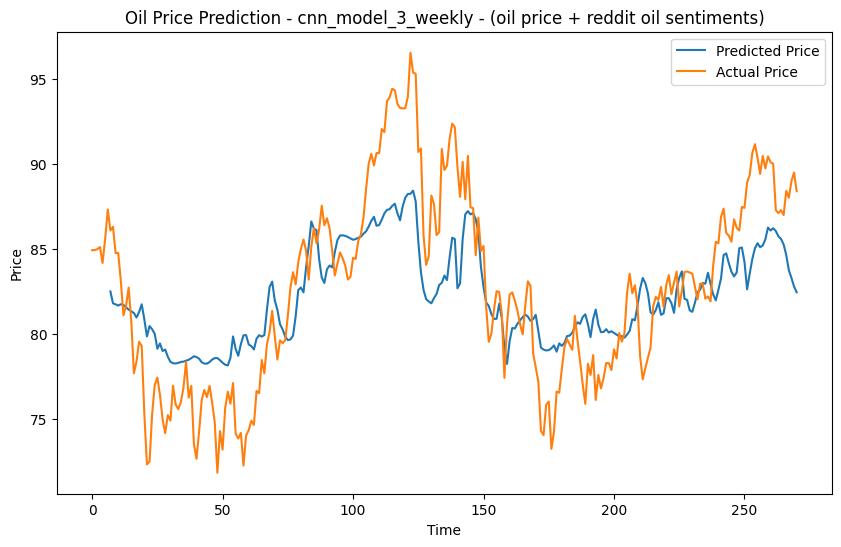

257/257 [==============================] - 0s 1ms/step


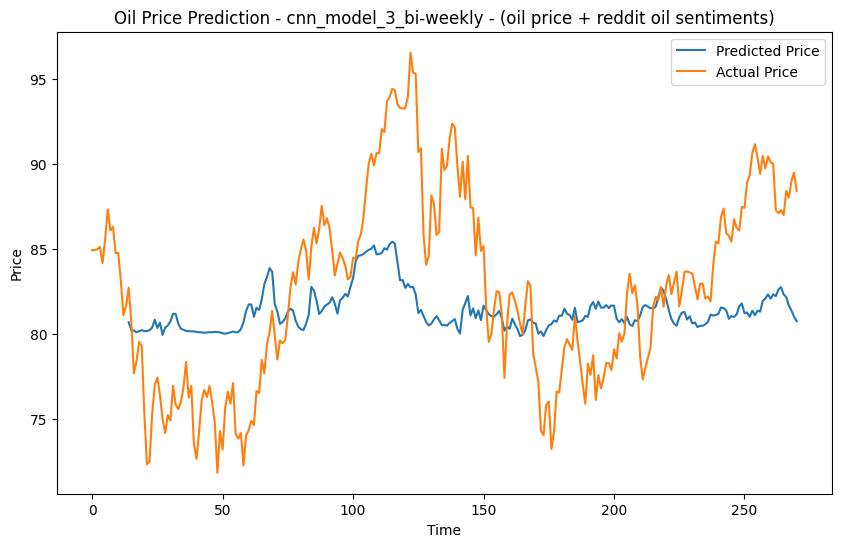

241/241 [==============================] - 0s 2ms/step


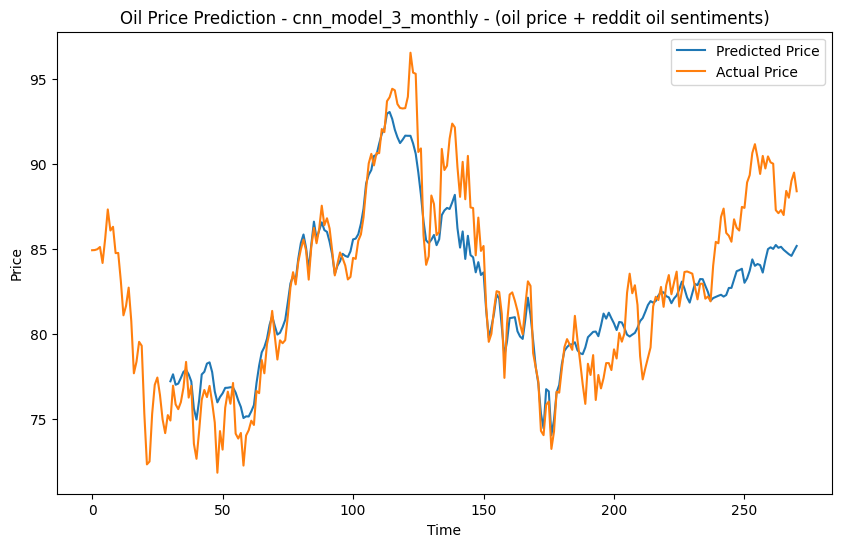

264/264 [==============================] - 0s 1ms/step


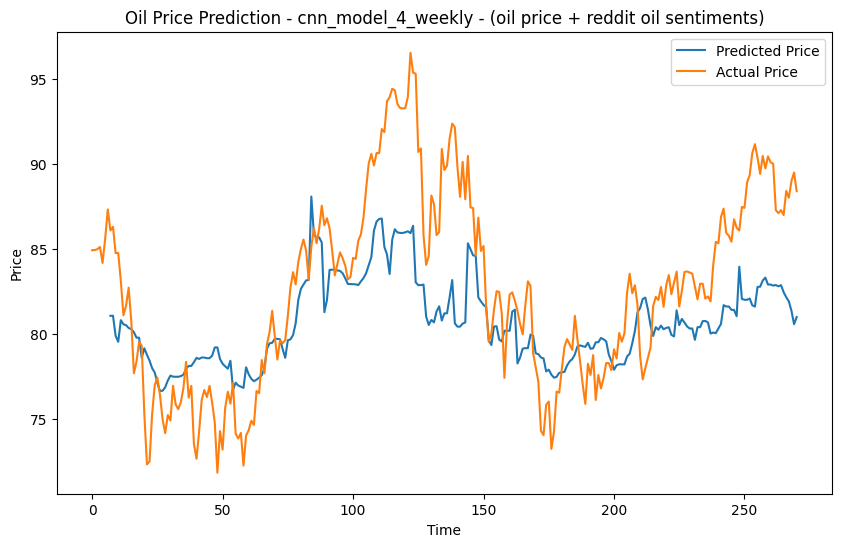

257/257 [==============================] - 0s 1ms/step


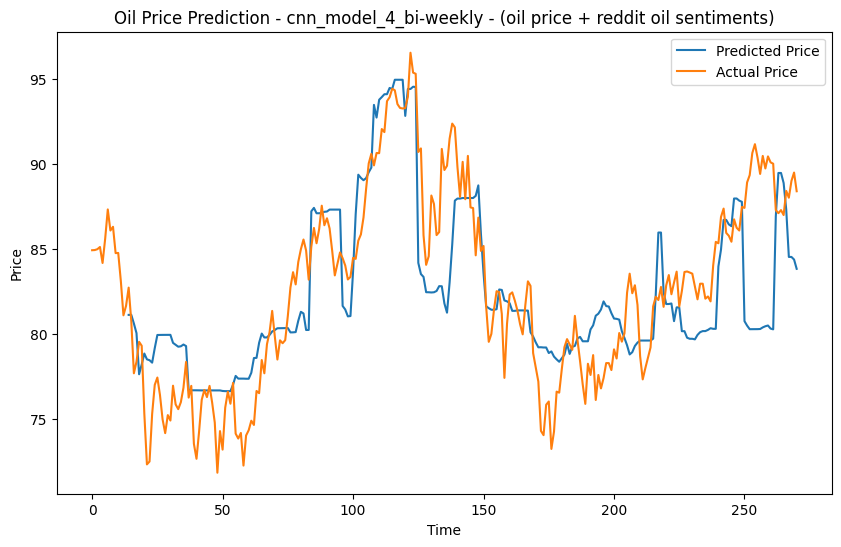

241/241 [==============================] - 0s 1ms/step


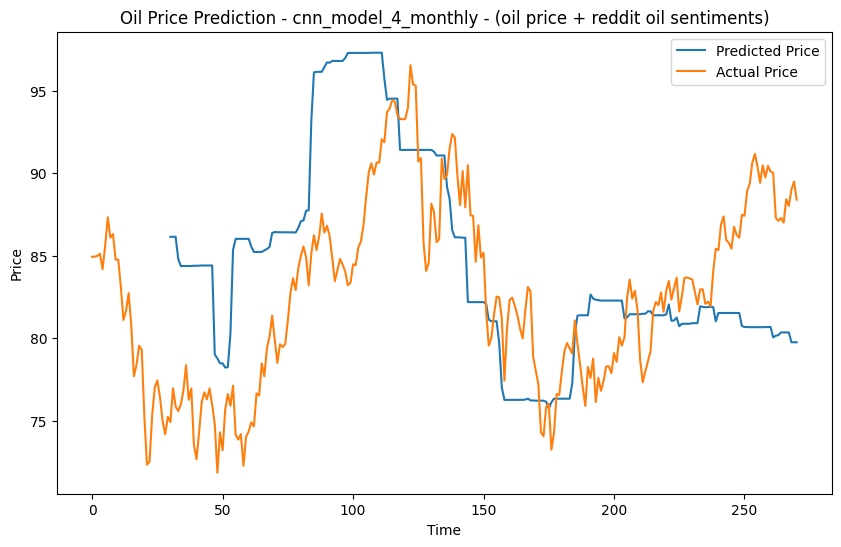

264/264 [==============================] - 0s 2ms/step


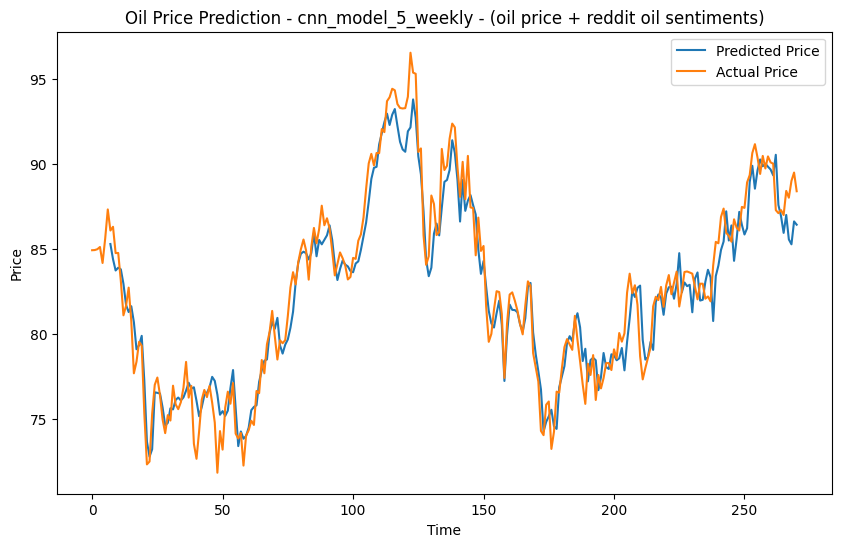

257/257 [==============================] - 0s 1ms/step


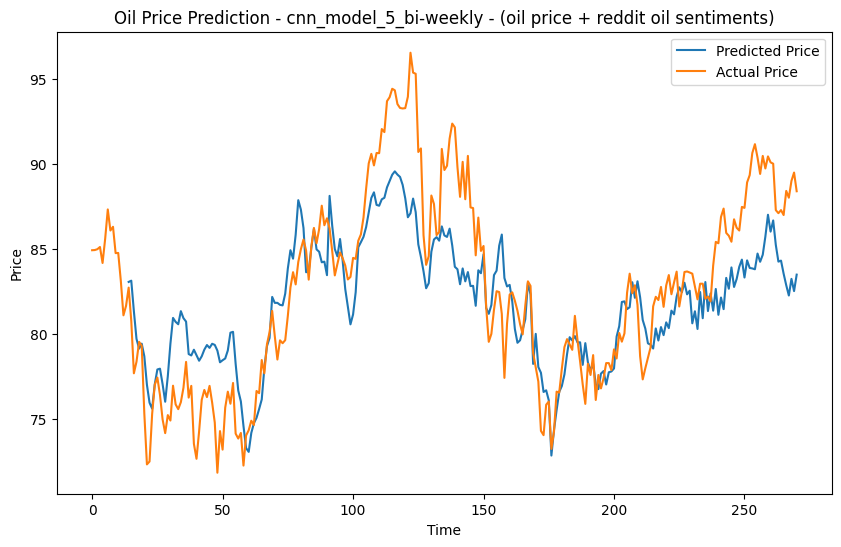

241/241 [==============================] - 0s 1ms/step


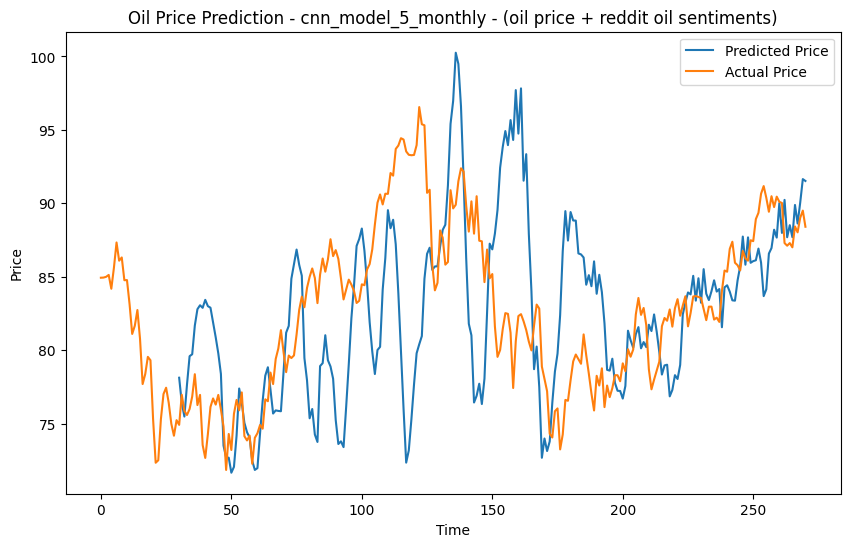

In [62]:
# Plot predictions vs actual values

# Y_test = np.array([s[1][0][0][0].numpy() for s in iter(window.test)])
Y_all_data = oil_data['Price'].values
Y_all_data = scaler.inverse_transform(Y_all_data.reshape(-1, 1))

for model_name in models_list:
    model = models_list[model_name]['model']
    window = models_list[model_name]['window']
    seq_length = models_list[model_name]['seq_length']

    all_predict = model.predict(window.all_data)
    try:

        X_all_data = scaler.inverse_transform(all_predict)

        plt.figure(figsize=(10, 6))
        plt.plot(range(seq_length, seq_length + len(X_all_data)), X_all_data, label='Predicted Price')
        plt.plot(range(len(Y_all_data)), Y_all_data, label='Actual Price')
        plt.title(f'Oil Price Prediction - {model_name} - (oil price + reddit oil sentiments)')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.savefig(f'outputs/oil_reddit_oil/CNN {model_name} Oil Price Prediction.png')
        plt.show()
    except:
        print("Error", model_name, all_predict.shape)